### run sequence
#### 1. old code or new code(ours) 
#### 2. The others run sequentially 

# old code

In [1]:
import torch
import torch.nn as nn
from typing import List, Tuple

def static_loss(model: nn.Module, f: torch.Tensor, f_bc: torch.Tensor, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    """
    Compute the loss between the model's predictions and the true labels.
    
    Args:
        model: The neural network model.
        f: Input tensor for the first branch.
        f_bc: Input tensor for the second branch.
        x: Input tensor for the trunk.
        y: True labels.
    
    Returns:
        torch.Tensor: The computed loss.
    """
    y_out = model.forward(f, f_bc, x)
    loss = ((y_out - y)**2).mean()
    return loss

def static_forward(model: nn.Module, f: torch.Tensor, f_bc: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
    """
    Perform the forward pass through the model.
    
    Args:
        model: The neural network model.
        f: Input tensor for the first branch.
        f_bc: Input tensor for the second branch.
        x: Input tensor for the trunk.
    
    Returns:
        torch.Tensor: The model's predictions.
    """
    y_br1 = model._branch1(f)
    y_br2 = model._branch2(f_bc)
    y_br = y_br1 * y_br2

    y_tr = model._trunk(x)
    y_out = torch.einsum("ij,kj->ik", y_br, y_tr)
    return y_out

def static_init(model: nn.Module, branch1_dim: List[int], branch2_dim: List[int], trunk_dim: List[int]) -> None:
    """
    Initialize the model's parameters and architecture.
    
    Args:
        model: The neural network model.
        branch1_dim: Dimensions for the first branch.
        branch2_dim: Dimensions for the second branch.
        trunk_dim: Dimensions for the trunk.
    """
    model.z_dim = trunk_dim[-1]

    # Build branch net for branch1
    modules = []
    in_channels = branch1_dim[0]
    for h_dim in branch1_dim[1:]:
        modules.append(nn.Sequential(
            nn.Linear(in_channels, h_dim),
            nn.Tanh()
        ))
        in_channels = h_dim
    model._branch1 = nn.Sequential(*modules)

    # Build branch net for branch2
    modules = []
    in_channels = branch2_dim[0]
    for h_dim in branch2_dim[1:]:
        modules.append(nn.Sequential(
            nn.Linear(in_channels, h_dim),
            nn.Tanh()
        ))
        in_channels = h_dim
    model._branch2 = nn.Sequential(*modules)

    # Build trunk net
    modules = []
    in_channels = trunk_dim[0]
    for h_dim in trunk_dim[1:]:
        modules.append(nn.Sequential(
            nn.Linear(in_channels, h_dim),
            nn.Tanh()
        ))
        in_channels = h_dim
    model._trunk = nn.Sequential(*modules)



# new code

In [ ]:
from dataclasses import dataclass
import torch.nn as nn
import torch
from typing import List
import numpy as np
def static_forward(model, f, f_bc, x):
    """
    Perform the forward pass through the model with simplified feature interaction.
    
    Args:
        model: The neural network model.
        f: Input tensor for the first branch.
        f_bc: Input tensor for the second branch.
        x: Input tensor for the trunk.
    
    Returns:
        torch.Tensor: The model's predictions.
    """
    # Process inputs through branches
    y_br1 = model._branch1(f)
    y_br2 = model._branch2(f_bc)
    
    # Combine branch outputs using element-wise multiplication
    y_br = y_br1 * y_br2
    
    # Process trunk input
    y_tr = model._trunk(x)
    
    # Combine branch and trunk outputs using Einstein summation
    y_out = torch.einsum("ij,kj->ik", y_br, y_tr)
    
    return y_out

def static_loss(model: nn.Module, f: torch.Tensor, f_bc: torch.Tensor, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    """
    Compute the loss between the model's predictions and the true labels using a weighted mean squared error.
    The weights are dynamically computed based on the magnitude of the true labels to emphasize larger errors.
    
    Args:
        model: The neural network model.
        f: Input tensor for the first branch.
        f_bc: Input tensor for the second branch.
        x: Input tensor for the trunk.
        y: True labels.
    
    Returns:
        torch.Tensor: The computed weighted loss.
    """
    y_out = model.forward(f, f_bc, x)
    # Compute weights based on the magnitude of the true labels
    weights = torch.abs(y) + 1.0  # Add 1 to avoid zero weights
    # Compute weighted mean squared error
    loss = (weights * (y_out - y)**2).mean()
    return loss

def static_init(model: nn.Module, branch1_dim: List[int], branch2_dim: List[int], trunk_dim: List[int]) -> None:
    """
    Initialize the model's parameters and architecture with enhanced flexibility and efficiency.
    
    Args:
        model: The neural network model.
        branch1_dim: Dimensions for the first branch.
        branch2_dim: Dimensions for the second branch.
        trunk_dim: Dimensions for the trunk.
    """
    model.z_dim = trunk_dim[-1]

    # Build branch net for branch1 with residual connections
    modules = []
    in_channels = branch1_dim[0]
    for i, h_dim in enumerate(branch1_dim[1:]):
        modules.append(nn.Sequential(
            nn.Linear(in_channels, h_dim),
            nn.Tanh()
        ))
        if i > 0 and h_dim == branch1_dim[i]:  # Add residual connection if dimensions match
            modules.append(nn.Linear(h_dim, h_dim))
        in_channels = h_dim
    model._branch1 = nn.Sequential(*modules)

    # Build branch net for branch2 with residual connections
    modules = []
    in_channels = branch2_dim[0]
    for i, h_dim in enumerate(branch2_dim[1:]):
        modules.append(nn.Sequential(
            nn.Linear(in_channels, h_dim),
            nn.Tanh()
        ))
        if i > 0 and h_dim == branch2_dim[i]:  # Add residual connection if dimensions match
            modules.append(nn.Linear(h_dim, h_dim))
        in_channels = h_dim
    model._branch2 = nn.Sequential(*modules)

    # Build trunk net with residual connections
    modules = []
    in_channels = trunk_dim[0]
    for i, h_dim in enumerate(trunk_dim[1:]):
        modules.append(nn.Sequential(
            nn.Linear(in_channels, h_dim),
            nn.Tanh()
        ))
        if i > 0 and h_dim == trunk_dim[i]:  # Add residual connection if dimensions match
            modules.append(nn.Linear(h_dim, h_dim))
        in_channels = h_dim
    model._trunk = nn.Sequential(*modules)

In [2]:
class opnn(torch.nn.Module):
        def __init__(self, branch1_dim, branch2_dim, trunk_dim):
            super(opnn, self).__init__()
            static_init(self,branch1_dim, branch2_dim, trunk_dim)

        def forward(self, f, f_bc, x):
            return static_forward(self,f, f_bc, x)
        
torch.cuda.empty_cache()

In [3]:
num_umode = 50
num_geomode = 20
dim_br_u = [num_umode, 300, 300, 200]
dim_br_geo = [num_geomode, 200, 200, 200]
dim_tr = [3, 200, 200, 200]

In [ ]:
import os
import torch
import time
import numpy as np
import scipy.io as io
import math
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle5 as pickle
from tqdm import tqdm

def to_numpy(input):
    if isinstance(input, torch.Tensor):
        return input.detach().cpu().numpy()
    elif isinstance(input, np.ndarray):
        return input
    else:
        raise TypeError('Unknown type of input, expected torch.Tensor or '\
            'np.ndarray, but got {}'.format(type(input)))

def static_main(model, epochs, device):
    ## hyperparameters
    '''
    args = ParseArgument()
    epochs = args.epochs
    device = args.device
    save_step = args.save_step
    test_model = args.test_model
    restart = args.test_model
    if test_model == 1:
        load_path = "./CheckPts/model_chkpts.pt"
        test_path = "./RD_plt_data.mat"
    if restart == 1:
        load_path = "./CheckPts/model_chkpts.pt"
    '''
    num_umode = 50
    num_geomode = 20
    if_normal = 0

    dim_br_u = [num_umode, 300, 300, 200]
    dim_br_geo = [num_geomode, 200, 200, 200]
    dim_tr = [3, 200, 200, 200]

    num_train = 2400
    num_test = 600
    num_cases = num_train + num_test

    ## create folders
    '''
    dump_train = './Predictions/Train/'
    dump_test = './Predictions/Test/'
    model_path = 'CheckPts/model_chkpts.pt'
    os.makedirs(dump_train, exist_ok=True)
    os.makedirs(dump_test, exist_ok=True)
    os.makedirs('CheckPts', exist_ok=True)
    '''
    ## dataset
    datafile = "/root/AEL-P-SNE/problems/dimon/RD/dataset_pod_affine.npy"
    dataset = np.load(datafile, allow_pickle=True)

    nskip = 2
    u_data = dataset['u_data'][:, ::nskip]

    x_data = dataset['x_uni']
    x_mesh = dataset["x_mesh_data"]
    f_u = dataset["coeff_u0"]
    f_g = dataset["coeff_geo"]

    ###############################
    ## expand x with time
    t = dataset["t"]
    t_num = t.shape[1]
    tx_ext = np.zeros((t_num, x_data.shape[0], 3))
    for i in range(0, t_num):
        tx_ext[i, :, 0] = t[0, i]
        tx_ext[i, :, 1:3] = x_data
    tx_ext = tx_ext[::nskip]
    num_snap = tx_ext.shape[0]
    num_pts = x_data.shape[0]
    tx_ext = tx_ext.reshape(-1, 3)
    ###############################

    ##########################
    ## testing/training dataset
    u_train = u_data[:num_train] # start from snapshot 1
    f_u_train = f_u[:num_train] # predict based on previous snapshot
    f_g_train = f_g[:num_train]

    u_test = u_data[num_train:(num_train+num_test)]    
    f_u_test = f_u[num_train:(num_train+num_test)]
    f_g_test = f_g[num_train:(num_train+num_test)]

    ## normalization
    if if_normal == 1:
        f_u_mean = f_u_train.mean(axis=0)
        f_u_std = f_u_train.std(axis=0)
        
        np.savetxt("./f_u_mean_std.txt", np.concatenate((f_u_mean[:, None], f_u_std[:, None]), axis=1))
        
        f_u_train = (f_u_train - f_u_mean)/f_u_std
        f_u_test = (f_u_test - f_u_mean)/f_u_std

    ## tensor
    u_train_tensor = torch.tensor(u_train, dtype=torch.float).to(device)
    f_u_train_tensor = torch.tensor(f_u_train, dtype=torch.float).to(device)
    f_g_train_tensor = torch.tensor(f_g_train, dtype=torch.float).to(device)

    f_u_test_tensor = torch.tensor(f_u_test, dtype=torch.float).to(device)
    f_g_test_tensor = torch.tensor(f_g_test, dtype=torch.float).to(device)
    xt_tensor = torch.tensor(tx_ext, dtype=torch.float).to(device)

    ## initialization
    #model = opnn(dim_br_u, dim_br_geo, dim_tr).to(device) ## note this is not POD-OPNN. Use POD mode to express functions
    model=model.to(device)
    model = model.float()
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.0002)
    flag = 1
    if flag == 1:
        train_loss = np.zeros((epochs, 1))
        test_loss = np.zeros((epochs, 1))
        '''
        if restart == 1:
            checkpoint = torch.load(load_path)
            model.load_state_dict(checkpoint['model_state_dict'])
        '''
        ## training
        def train(epoch, f_u, f_g, x, y):
            model.train()
            def closure():
                optimizer.zero_grad()
                y_pred = model.forward(f_u, f_g, x).reshape(-1, num_snap, num_pts)

                # print(y_pred.shape)
                # print(y.shape)
                # exit()

                loss = ((y_pred - y)**2).mean()
                train_loss[epoch, 0] = loss
                loss.backward()
                return loss
            optimizer.step(closure)

        ## Iterations
        print('start training...', flush=True)
        #-tic = time.time()
        for epoch in tqdm(range(epochs), desc='Training', unit='epoch'):
            if epoch == 50000:
                optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
            elif epoch == 90000:
                optimizer = torch.optim.Adam(model.parameters(), lr = 0.00001)


            ## Training
            train(epoch, f_u_train_tensor, f_g_train_tensor, xt_tensor, u_train_tensor)
            ## Testing
            y_pred = to_numpy(model.forward(f_u_test_tensor, f_g_test_tensor, xt_tensor).reshape(-1, num_snap, num_pts))
            loss_tmp = ((y_pred - u_test)**2).mean() # denote u_test as testing cardiac field
            test_loss[epoch, 0] = loss_tmp

            ## testing error
            #if epoch%5000 == 0:
            #    print(f'Epoch: {epoch}, Train Loss: {train_loss[epoch, 0]:.6f}, Test Loss: {test_loss[epoch, 0]:.6f}', flush=True)
            #    print(f'Epoch: {epoch}', flush=True)
            ## Save model
            model_path = '/root/AEL-P-SNE/problems/dimon/data_rd/model.pt'
            if (epoch+1)%epochs == 0: 
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                }, model_path)

        #toc = time.time()

        #print(f'total training time: {int((toc-tic)/60)} min', flush=True)
        #np.savetxt('./train_loss.txt', train_loss)
        #np.savetxt('./test_loss.txt', test_loss)
        '''
        ## plot loss function
        num_epoch = train_loss.shape[0]
        x = np.linspace(1, num_epoch, num_epoch)
        
        ## plot loss
        fig = plt.figure(constrained_layout=False, figsize=(6, 6))
        gs = fig.add_gridspec(1, 1)

        ax = fig.add_subplot(gs[0])
        ax.plot(x, train_loss.mean(axis=1), color='blue', label='Training Loss')
        ax.plot(x, test_loss.mean(axis=1), color='red', label='Test Loss', linestyle='dashed')
        ax.set_yscale('log')
        ax.set_ylabel('Loss')
        ax.set_xlabel('Epochs')
        ax.legend(loc='upper left')

        fig.savefig('./loss_his.png')
        '''
        ## save train
        u_train_pred = model.forward(f_u_train_tensor, f_g_train_tensor, xt_tensor).reshape(-1, num_snap, num_pts)
        u_pred = to_numpy(u_train_pred)
        u_true = u_train
        num_t = u_train.shape[1]

        
        for i in range(0, 10):
            u_pred_plot = u_pred[i, :]
            u_true_plot = u_true[i, :]
            #os.makedirs(dump_train + str(i), exist_ok=True)
            print(f"printing training case: {i}")

            
            for tt in range(0, num_t):
                fig = plt.figure(constrained_layout=False, figsize=(15, 5))
                gs = fig.add_gridspec(1, 3)

                ax = fig.add_subplot(gs[0])
                # h = ax.imshow(u_true_plot[tt], label="True", vmin=-0.75, vmax=1)
                h = ax.scatter(x_mesh[i, :, 0], x_mesh[i, :, 1], c =u_true_plot[tt])
                ax.set_aspect(1)
                plt.colorbar(h)
                ax.set_title("True data")

                ax = fig.add_subplot(gs[1])
                # h = ax.imshow(u_pred_plot[tt], label="Pred", vmin=-0.75, vmax=1)
                h = ax.scatter(x_mesh[i, :, 0], x_mesh[i, :, 1], c=u_pred_plot[tt])
                ax.set_aspect(1)
                plt.colorbar(h)
                ax.set_title("prediction")

                ax = fig.add_subplot(gs[2])
                # h = ax.imshow(u_pred_plot[tt] - u_true_plot[tt], label="Pred")
                h = ax.scatter(x_mesh[i, :, 0], x_mesh[i, :, 1], c=u_pred_plot[tt] - u_true_plot[tt])
                ax.set_aspect(1)
                plt.colorbar(h)
                ax.set_title("err")
                dump_train = ''
                fig.savefig(dump_train + str(i) + '/snapshot_1' + str(tt) + '.png')
                plt.close()
        '''
        ## save test
        u_test_pred = model.forward(f_u_test_tensor, f_g_test_tensor, xt_tensor).reshape(-1,num_snap, num_pts)
        u_pred = to_numpy(u_test_pred)
        u_true = u_test
        '''
        dump_test = ''
        for i in range(0, 10):
            u_pred_plot = u_pred[i, :]
            u_true_plot = u_true[i, :]
            os.makedirs(dump_test + str(i), exist_ok=True)
            print(f"printing testing case: {i}")

            for tt in range(0, num_t):
                fig = plt.figure(constrained_layout=False, figsize=(15, 5))
                gs = fig.add_gridspec(1, 3)

                ## 
                ax = fig.add_subplot(gs[0])
                # h = ax.imshow(u_true_plot[tt], label="True", vmin=-0.75, vmax=1)
                h = ax.scatter(x_mesh[i, :, 0], x_mesh[i, :, 1], c=u_true_plot[tt])
                ax.set_aspect(1)
                plt.colorbar(h)
                ax.set_title("True data")

                ax = fig.add_subplot(gs[1])
                # h = ax.imshow(u_pred_plot[tt], label="Pred", vmin=-0.75, vmax=1)
                h = ax.scatter(x_mesh[i, :, 0], x_mesh[i, :, 1], c =u_pred_plot[tt])
                ax.set_aspect(1)
                plt.colorbar(h)
                ax.set_title("prediction")

                ax = fig.add_subplot(gs[2])
                # h = ax.imshow(u_pred_plot[tt] - u_true_plot[tt], label="Pred")
                h = ax.scatter(x_mesh[i, :, 0], x_mesh[i, :, 1], c=u_pred_plot[tt] - u_true_plot[tt])
                ax.set_aspect(1)
                plt.colorbar(h)
                ax.set_title("err")

                fig.savefig(dump_test + str(i) + '/snapshot_' + str(tt) + '.png')
                plt.close()
                '''
    '''
        checkpoint = torch.load(load_path)
        model.load_state_dict(checkpoint['model_state_dict'])


In [5]:
rel_l2_err=static_main(opnn(dim_br_u, dim_br_geo, dim_tr), 100000, 'cuda')

start training...
Epoch: 0
Epoch: 5000


KeyboardInterrupt: 

In [12]:
print(rel_l2_err.mean())

1.0027600099874545


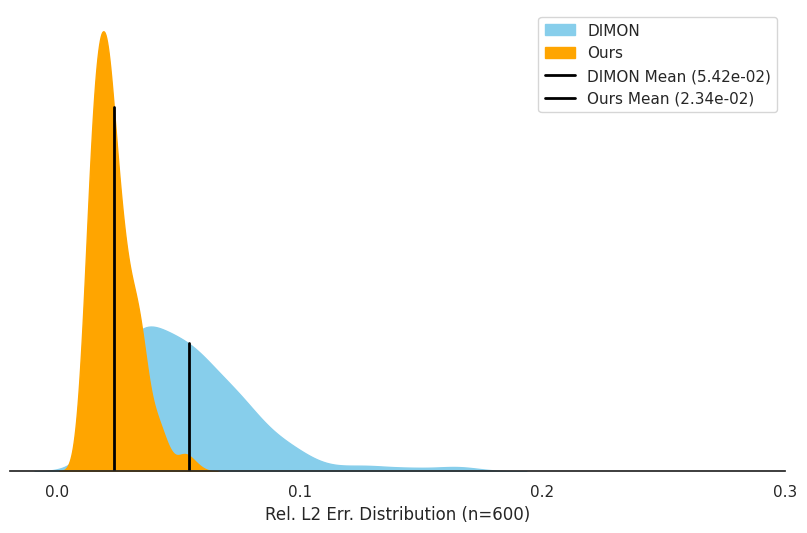

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

def load_data(file_path):

    with open(file_path, 'r') as file:
        lines = file.readlines()
        data = [float(line.strip()) for line in lines]
    return data


file_path_group1 = 'ReactionDiffusion/plot_data/rel_l2_err_rd_1_600.txt' 
file_path_group2 = 'ReactionDiffusion/plot_data/rel_l2_err_rd_1_ours_600.txt'  


data_group1 = load_data(file_path_group1)
data_group2 = load_data(file_path_group2)


df_group1 = pd.DataFrame(data_group1, columns=['Value'])
df_group1['Group'] = 'DIMON'

df_group2 = pd.DataFrame(data_group2, columns=['Value'])
df_group2['Group'] = 'Ours'


df_combined = pd.concat([df_group1, df_group2], ignore_index=True)


sns.set(style="white")


plt.figure(figsize=(10, 6))


kde_dimon = sns.kdeplot(
    data=df_combined[df_combined['Group'] == 'DIMON'], 
    x='Value', 
    fill=True, 
    color='skyblue',
    label='DIMON',
    alpha=1  
)

kde_ours = sns.kdeplot(
    data=df_combined[df_combined['Group'] == 'Ours'], 
    x='Value', 
    fill=True, 
    color='orange', 
    label='Ours',
    alpha=1 
)

mean_group1 = df_group1['Value'].mean()
mean_group2 = df_group2['Value'].mean()


kde_dimon_dist = stats.gaussian_kde(df_group1['Value'])
kde_ours_dist = stats.gaussian_kde(df_group2['Value'])


x = np.linspace(min(df_combined['Value']), max(df_combined['Value']), 1000)


y_mean_group1 = kde_dimon_dist(mean_group1)[0]
y_mean_group2 = kde_ours_dist(mean_group2)[0]


plt.plot([mean_group1, mean_group1], [0, y_mean_group1], linestyle='-', color='black', linewidth=2, label=f'DIMON Mean ({mean_group1:.2e})')
plt.plot([mean_group2, mean_group2], [0, y_mean_group2], linestyle='-', color='black', linewidth=2, label=f'Ours Mean ({mean_group2:.2e})')


plt.xlabel('Rel. L2 Err. Distribution (n=600)')


ax = plt.gca()
ax.set_xticks([0.0, 0.1, 0.2, 0.3])


ax.yaxis.set_visible(False)


sns.despine(left=True)

plt.legend()

plt.show()